In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from math import floor
from termcolor import colored as cl 


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [54]:
# set ticker
ticker = "XLNX"

# set timeframe for data
start = '2010-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close   Volume
Date                                                           
2010-01-04  25.340000  25.620001  25.230000  25.379999  2824700
2010-01-05  25.330000  25.480000  24.850000  25.059999  3469700
2010-01-06  25.000000  25.379999  24.700001  24.889999  6329200
2010-01-07  24.860001  24.860001  24.350000  24.639999  9252700
2010-01-08  24.540001  25.049999  24.389999  25.000000  5005800

### Filter the dataset

In [55]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes.
# signals_df['Target'] = (
#     (np.where(signals_df['Actual Returns'] > 0.01, 1.0, 0.0)) + 
#     (np.where(signals_df['Actual Returns'] < -0.01, -1.0, 0.0))
# )


signals_df['Target'] = np.where(signals_df['Actual Returns'].shift(-1) > 0, 1, 0)


# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())


# signals_df['Target'].value_counts()


Close  Actual Returns  Target
Date                                         
2010-01-05  25.059999       -0.012608       0
2010-01-06  24.889999       -0.006784       0
2010-01-07  24.639999       -0.010044       1
2010-01-08  25.000000        0.014610       0
2010-01-11  24.740000       -0.010400       0

Close  Actual Returns  Target
Date                                          
2020-12-24  141.990005        0.000000       0
2020-12-28  141.520004       -0.003310       0
2020-12-29  139.899994       -0.011447       1
2020-12-30  142.100006        0.015726       0
2020-12-31  141.770004       -0.002322       0

## Generate trading signals
---

### RSI

RSI = 100 – [100 / ( 1 + (EMA_up / EMA_down) ) ] where,

EMAup = Exponential Moving Average of Upward Price Change

EMAdown = Exponential Moving Average of Downward Price Change

In [133]:
# Set RSI trading window
RSI_window = 14

#create new df for bollinger bands
RSI_df = signals_df.copy()

#Create function for RSI calculation
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

RSI_df [f'rsi'] = get_rsi(RSI_df['Close'], RSI_window)
RSI_df = RSI_df.dropna()
RSI_df

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                    
2010-01-15   23.520000       -0.024471       1        0.0         0.0   
2010-01-19   23.879999        0.015306       1        0.0         0.0   
2010-01-20   23.940001        0.002513       1        0.0         0.0   
2010-01-21   25.250000        0.054720       0        0.0         0.0   
2010-01-22   23.840000       -0.055842       1        0.0         0.0   
...                ...             ...     ...        ...         ...   
2020-12-24  141.990005        0.000000       0        1.0         0.0   
2020-12-28  141.520004       -0.003310       0        1.0         0.0   
2020-12-29  139.899994       -0.011447       1        1.0         0.0   
2020-12-30  142.100006        0.015726       0        1.0         0.0   
2020-12-31  141.770004       -0.002322       0        0.0         0.0   

            SMA_signal        rsi  
Date                               
2010-01-15         0.0  12.378380  
2010-01-19         0.0  30.735620  
2010-01-20         0.0  33.245883  
2010-01-21         0.0  63.958111  
2010-01-22         0.0  41.712908  
...                ...        ...  
2020-12-24         1.0  50.922733  
2020-12-28         1.0  50.087383  
2020-12-29         1.0  47.212519  
2020-12-30         1.0  51.300470  
2020-12-31         1.0  50.666640  

[2760 rows x 7 columns]

In [134]:
#RSI Trading Signal

upper_limit = 70
lower_limit = 30


# Calculate rolling mean and standard deviation
RSI_df['RSI_mid_band'] = RSI_df['Close'].rolling(window=RSI_window).mean()
RSI_df['RSI_std'] = RSI_df['Close'].rolling(window=14).std()

# Calculate upper and lowers bands of bollinger band
RSI_df['RSI_upper_band']  = RSI_df['RSI_mid_band'] + (RSI_df['RSI_std'] * 1)
RSI_df['RSI_lower_band']  = RSI_df['RSI_mid_band'] - (RSI_df['RSI_std'] * 1)


# Calculate RSI trading signal
# RSI_df['RSI_long'] = np.where(RSI_df['rsi'] < lower_limit, 1.0, 0.0)
# RSI_df['RSI_short'] = np.where(RSI_df['rsi'] > upper_limit, -1.0, 0.0)
# RSI_df['RSI_signal'] = RSI_df['RSI_long'] + RSI_df['RSI_short']

RSI_df['RSI_signal'] = np.where(RSI_df['rsi'].shift(-1) < lower_limit, 1.0, 0)

    
RSI_df['RSI_signal'].value_counts()

0.0    2682
1.0      78
Name: RSI_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

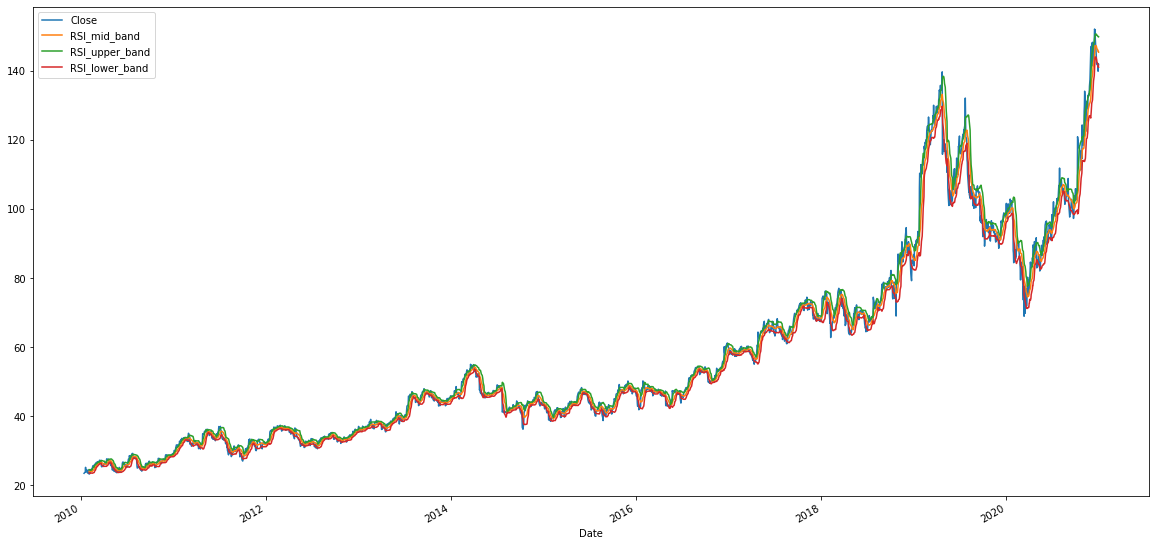

In [135]:
# Plot the RSI for closing prices
RSI_df[['Close','RSI_mid_band','RSI_upper_band','RSI_lower_band']].plot(figsize=(20,10))

In [136]:
# Calculate the strategy returns and add them to the signals_df DataFrame
RSI_df['Strategy Returns'] = RSI_df['Actual Returns'] * RSI_df['RSI_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
RSI_df['exit'] = RSI_df[RSI_df['Entry/Exit'] == 0]['Close']
RSI_df['entry'] = RSI_df[RSI_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(RSI_df.head())
display(RSI_df.tail())

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                   
2010-01-15  23.520000       -0.024471       1        0.0         0.0   
2010-01-19  23.879999        0.015306       1        0.0         0.0   
2010-01-20  23.940001        0.002513       1        0.0         0.0   
2010-01-21  25.250000        0.054720       0        0.0         0.0   
2010-01-22  23.840000       -0.055842       1        0.0         0.0   

            SMA_signal        rsi  RSI_mid_band  RSI_std  RSI_upper_band  \
Date                                                                       
2010-01-15         0.0  12.378380           NaN      NaN             NaN   
2010-01-19         0.0  30.735620           NaN      NaN             NaN   
2010-01-20         0.0  33.245883           NaN      NaN             NaN   
2010-01-21         0.0  63.958111           NaN      NaN             NaN   
2010-01-22         0.0  41.712908           NaN      NaN             NaN   

            RSI_lower_band  Strategy Returns  Entry/Exit       exit  entry  
Date                                                                        
2010-01-15             NaN               NaN         NaN        NaN    NaN  
2010-01-19             NaN               0.0         0.0  23.879999    NaN  
2010-01-20             NaN               0.0         0.0  23.940001    NaN  
2010-01-21             NaN               0.0         0.0  25.250000    NaN  
2010-01-22             NaN              -0.0         0.0  23.840000    NaN

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                    
2020-12-24  141.990005        0.000000       0        1.0         0.0   
2020-12-28  141.520004       -0.003310       0        1.0         0.0   
2020-12-29  139.899994       -0.011447       1        1.0         0.0   
2020-12-30  142.100006        0.015726       0        1.0         0.0   
2020-12-31  141.770004       -0.002322       0        0.0         0.0   

            SMA_signal        rsi  RSI_mid_band   RSI_std  RSI_upper_band  \
Date                                                                        
2020-12-24         1.0  50.922733    146.493573  3.846900      150.340473   
2020-12-28         1.0  50.087383    146.011430  4.025959      150.037389   
2020-12-29         1.0  47.212519    145.562144  4.342989      149.905133   
2020-12-30         1.0  51.300470    145.612144  4.295151      149.907295   
2020-12-31         1.0  50.666640    145.462859  4.395874      149.858733   

            RSI_lower_band  Strategy Returns  Entry/Exit        exit  entry  
Date                                                                         
2020-12-24      142.646673               0.0         0.0  141.990005    NaN  
2020-12-28      141.985471              -0.0         0.0  141.520004    NaN  
2020-12-29      141.219154              -0.0         0.0  139.899994    NaN  
2020-12-30      141.316994               0.0         0.0  142.100006    NaN  
2020-12-31      141.066985              -0.0         0.0  141.770004    NaN

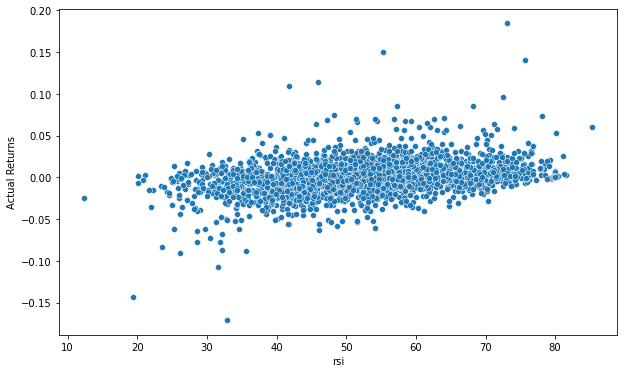

In [137]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=RSI_df['rsi'], y=RSI_df['Actual Returns']);

### Bollinger Bands

In [138]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bands
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
# bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
# bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
# bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']

bb_df['bollinger_signal'] = np.where(bb_df['Close'].shift(-1) < bb_df['bollinger_lower_band'], 1.0, 0)



bb_df['bollinger_signal'].value_counts()

0.0    2125
1.0     639
Name: bollinger_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

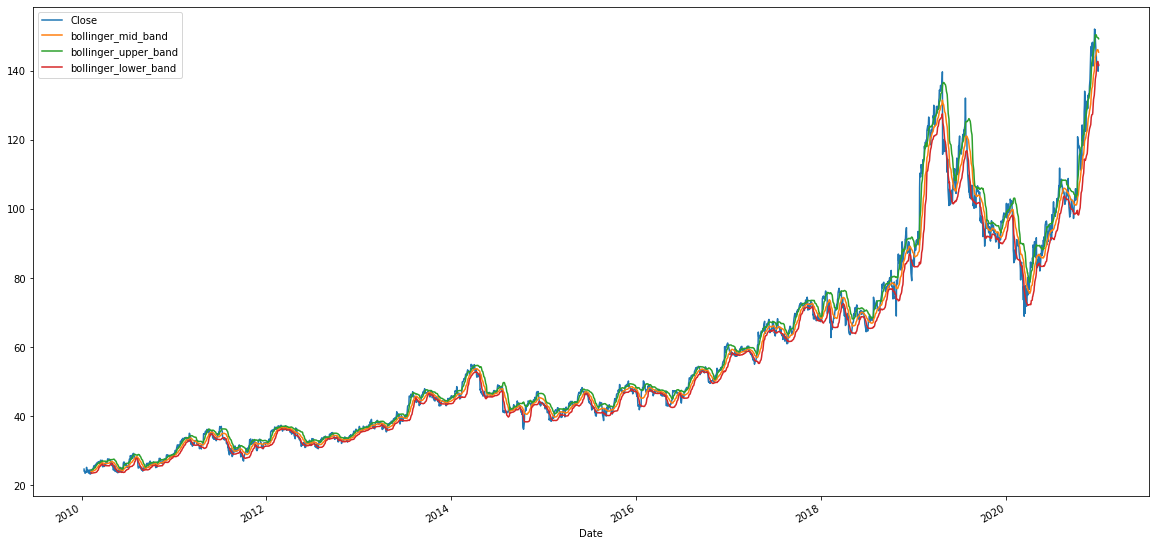

In [139]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [140]:
# Calculate the strategy returns and add them to the signals_df DataFrame
bb_df['Strategy Returns'] = bb_df['Actual Returns'] * bb_df['bollinger_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
bb_df['Entry/Exit'] = bb_df['bollinger_signal'].diff()

# # Visualize exit position relative to close price
bb_df['exit'] = bb_df[bb_df['Entry/Exit'] == 0]['Close']
bb_df['entry'] = bb_df[bb_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(bb_df.head())
display(bb_df.tail())

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                   
2010-01-11  24.740000       -0.010400       0        0.0         1.0   
2010-01-12  24.049999       -0.027890       1        0.0         1.0   
2010-01-13  24.260000        0.008732       0        0.0         1.0   
2010-01-14  24.110001       -0.006183       0        0.0         1.0   
2010-01-15  23.520000       -0.024471       1        0.0         0.0   

            SMA_signal  bollinger_mid_band  bollinger_std  \
Date                                                        
2010-01-11         0.0                 NaN            NaN   
2010-01-12         0.0                 NaN            NaN   
2010-01-13         0.0                 NaN            NaN   
2010-01-14         0.0                 NaN            NaN   
2010-01-15         0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_signal  \
Date                                                                       
2010-01-11                   NaN                   NaN               0.0   
2010-01-12                   NaN                   NaN               0.0   
2010-01-13                   NaN                   NaN               0.0   
2010-01-14                   NaN                   NaN               0.0   
2010-01-15                   NaN                   NaN               0.0   

            Strategy Returns  Entry/Exit       exit  entry  
Date                                                        
2010-01-11               NaN         NaN        NaN    NaN  
2010-01-12              -0.0         0.0  24.049999    NaN  
2010-01-13               0.0         0.0  24.260000    NaN  
2010-01-14              -0.0         0.0  24.110001    NaN  
2010-01-15              -0.0         0.0  23.520000    NaN

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                    
2020-12-24  141.990005        0.000000       0        1.0         0.0   
2020-12-28  141.520004       -0.003310       0        1.0         0.0   
2020-12-29  139.899994       -0.011447       1        1.0         0.0   
2020-12-30  142.100006        0.015726       0        1.0         0.0   
2020-12-31  141.770004       -0.002322       0        0.0         0.0   

            SMA_signal  bollinger_mid_band  bollinger_std  \
Date                                                        
2020-12-24         1.0          145.958002       3.810598   
2020-12-28         1.0          146.159502       3.426439   
2020-12-29         1.0          145.877001       3.701231   
2020-12-30         1.0          145.692001       3.796524   
2020-12-31         1.0          145.425002       3.878442   

            bollinger_upper_band  bollinger_lower_band  bollinger_signal  \
Date                                                                       
2020-12-24            149.768599            142.147404               1.0   
2020-12-28            149.585941            142.733062               1.0   
2020-12-29            149.578232            142.175770               1.0   
2020-12-30            149.488526            141.895477               1.0   
2020-12-31            149.303443            141.546560               0.0   

            Strategy Returns  Entry/Exit        exit       entry  
Date                                                              
2020-12-24          0.000000         1.0         NaN  141.990005  
2020-12-28         -0.003310         0.0  141.520004         NaN  
2020-12-29         -0.011447         0.0  139.899994         NaN  
2020-12-30          0.015726         0.0  142.100006         NaN  
2020-12-31         -0.002322        -1.0         NaN         NaN

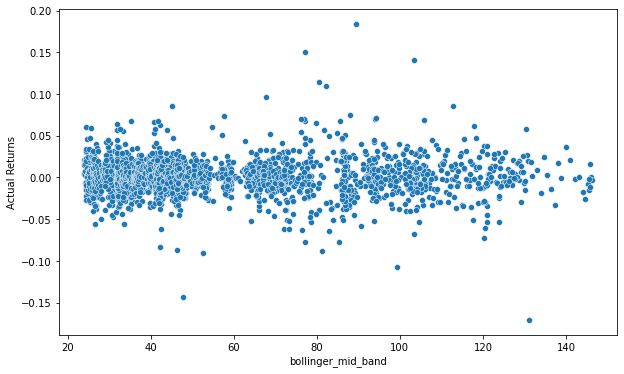

In [141]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=bb_df['bollinger_mid_band'], y=bb_df['Actual Returns']);

## EMA

In [142]:
# ema_df = stock_data.loc[:, ["Close"]]

# short_window = 1
# long_window = 10

# # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
# ema_df['fast_close'] = ema_df['Close'].ewm(halflife=short_window).mean()
# ema_df['slow_close'] = ema_df['Close'].ewm(halflife=long_window).mean()

# # Construct a crossover trading signal
# ema_df['crossover_long'] = np.where(ema_df['fast_close'] > ema_df['slow_close'], 1.0, 0.0)
# ema_df['crossover_short'] = np.where(ema_df['fast_close'] < ema_df['slow_close'], -1.0, 0.0)
# ema_df['crossover_signal'] = ema_df['crossover_long'] + ema_df['crossover_short']


# # Generate the short and long moving averages (50 and 100 days, respectively)
# ema_df["SMA50"] = ema_df["Close"].rolling(window=short_window).mean()
# ema_df["SMA100"] = ema_df["Close"].rolling(window=long_window).mean()
# ema_df["Signal"] = 0.0

# # Generate the trading signal 0 or 1,
# # where 0 is when the SMA50 is under the SMA100, and
# # where 1 is when the SMA50 is higher (or crosses over) the SMA100
# ema_df["Signal"][short_window:] = np.where(
#     ema_df["SMA50"][short_window:] > ema_df["SMA100"][short_window:], 1.0, 0.0
# )

# # Calculate the points in time at which a position should be taken, 1 or -1
# ema_df["Entry/Exit"] = ema_df["Signal"].diff()


In [143]:
# Visualize exit position relative to close price
# exit = ema_df[ema_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
#     color='red',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize entry position relative to close price
# entry = ema_df[ema_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
#     color='green',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize close price for the investment
# security_close = ema_df[['Close']].hvplot(
#     line_color='lightgray',
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize moving averages
# moving_avgs = ema_df[['SMA50', 'SMA100']].hvplot(
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Overlay plots
# entry_exit_plot = security_close * moving_avgs * entry * exit
# entry_exit_plot.opts(xaxis=None)

## SMA

In [144]:
# Set the windows
short_window = 50
long_window = 100

sma_df = signals_df.copy()

# Generate the short (50 days) and long moving averages(100 days) 
sma_df["SMA50"] = sma_df["Close"].rolling(window=short_window).mean()
sma_df["SMA100"] = sma_df["Close"].rolling(window=long_window).mean()
sma_df["Signal"] = 0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
sma_df["Signal"][short_window:] = np.where(
    sma_df["SMA50"][short_window:] > sma_df["SMA100"][short_window:], 1.0, 0
)

# Calculate the points in time at which a position should be taken, 1 or -1
sma_df["Entry/Exit"] = sma_df["Signal"].diff()


# Visualize exit point compared to closing price
exit = sma_df[sma_df['Entry/Exit'] == 0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = sma_df[sma_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = sma_df[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = sma_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)


<ipython-input-144-f1c9d34e95bc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_df["Signal"][short_window:] = np.where(


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [145]:
sma_df['Signal'].value_counts()

1.0    1706
0.0    1058
Name: Signal, dtype: int64

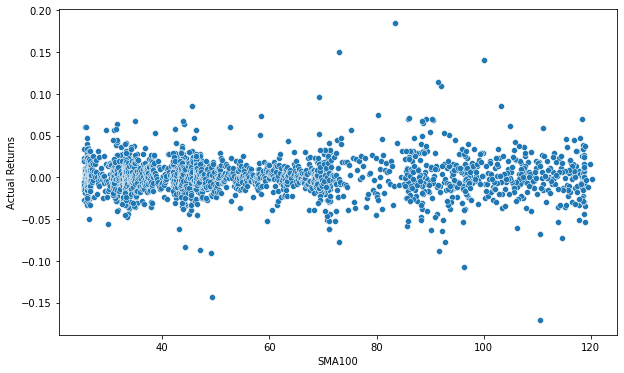

In [146]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=sma_df['SMA100'], y=sma_df['Actual Returns']);

## MACD

In [147]:
MACD_df = signals_df.copy()

# Calulate the Short and Long EMA
EMA_short = MACD_df.Close.ewm(span=12, adjust=False).mean()
EMA_long = MACD_df.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()


MACD_df["MACD"] = MACD
MACD_df["Signal"] = signal
MACD_df

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = 0
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != 0:
                Exit.append(signal["Close"][i])
                flag = 0
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit, flag)

data = entry_exit(MACD_df)
MACD_df["Entry_Point"] = data[0]
MACD_df["Exit_Point"] = data[1]
MACD_df["flag"] = data[2]



MACD_df['MACD Entry/Exit'] = MACD_df['Signal'].diff()

MACD_df.where(~MACD_df['Entry_Point'].notna(), 1) 

# MACD_df['flag'].value_counts()
# MACD_df

Close  Actual Returns  Target  BB_signal  RSI_signal  \
Date                                                                    
2010-01-11   24.740000       -0.010400       0        0.0         1.0   
2010-01-12   24.049999       -0.027890       1        0.0         1.0   
2010-01-13   24.260000        0.008732       0        0.0         1.0   
2010-01-14   24.110001       -0.006183       0        0.0         1.0   
2010-01-15   23.520000       -0.024471       1        0.0         0.0   
...                ...             ...     ...        ...         ...   
2020-12-24  141.990005        0.000000       0        1.0         0.0   
2020-12-28  141.520004       -0.003310       0        1.0         0.0   
2020-12-29  139.899994       -0.011447       1        1.0         0.0   
2020-12-30  142.100006        0.015726       0        1.0         0.0   
2020-12-31  141.770004       -0.002322       0        0.0         0.0   

            SMA_signal      MACD    Signal  Entry_Point  Exit_Point  flag  \
Date                                                                        
2010-01-11         0.0  0.000000  0.000000          NaN         NaN     0   
2010-01-12         0.0 -0.050954 -0.010191          NaN         NaN     0   
2010-01-13         0.0 -0.074485 -0.023050          NaN         NaN     0   
2010-01-14         0.0 -0.102963 -0.039032          NaN         NaN     0   
2010-01-15         0.0 -0.167434 -0.064712          NaN         NaN     0   
...                ...       ...       ...          ...         ...   ...   
2020-12-24         1.0  2.780430  4.209453          NaN         NaN     0   
2020-12-28         1.0  2.286715  3.824905          NaN         NaN     0   
2020-12-29         1.0  1.754601  3.410844          NaN         NaN     0   
2020-12-30         1.0  1.481238  3.024923          NaN         NaN     0   
2020-12-31         1.0  1.225835  2.665105          NaN         NaN     0   

            MACD Entry/Exit  
Date                         
2010-01-11              NaN  
2010-01-12        -0.010191  
2010-01-13        -0.012859  
2010-01-14        -0.015983  
2010-01-15        -0.025680  
...                     ...  
2020-12-24        -0.357256  
2020-12-28        -0.384548  
2020-12-29        -0.414061  
2020-12-30        -0.385921  
2020-12-31        -0.359818  

[2764 rows x 12 columns]

### Compiling Signals

In [148]:
# Compiling Signals
signals = []
    
# # Bollinger Bands
col_name = 'BB_signal'
signals_df[col_name] = bb_df['bollinger_signal']
signals.append(col_name)

# RSI
col_name = 'RSI_signal'
signals_df[col_name] = RSI_df['RSI_signal']
signals.append(col_name)

# # # SMA
col_name = 'SMA_signal'
signals_df[col_name] = sma_df['Signal']
signals.append(col_name)

# # # #EMA
# col_name = 'EMA_signal'
# signals_df[col_name] = ema_df['Entry/Exit']
# signals.append(col_name)

# MACD
# col_name = 'MACD_signal'
# signals_df[col_name] = MACD_df['flag']
# signals.append(col_name)


signals

['BB_signal', 'RSI_signal', 'SMA_signal']

In [149]:
# Removing nan values
signals_df.dropna(inplace=True)

In [150]:
signals_df[signals+['Target']]

BB_signal  RSI_signal  SMA_signal  Target
Date                                                 
2010-01-15        0.0         0.0         0.0       1
2010-01-19        0.0         0.0         0.0       1
2010-01-20        0.0         0.0         0.0       1
2010-01-21        0.0         0.0         0.0       0
2010-01-22        0.0         0.0         0.0       1
...               ...         ...         ...     ...
2020-12-24        1.0         0.0         1.0       0
2020-12-28        1.0         0.0         1.0       0
2020-12-29        1.0         0.0         1.0       1
2020-12-30        1.0         0.0         1.0       0
2020-12-31        0.0         0.0         1.0       0

[2760 rows x 4 columns]

### Visualize Relationship Among Signals

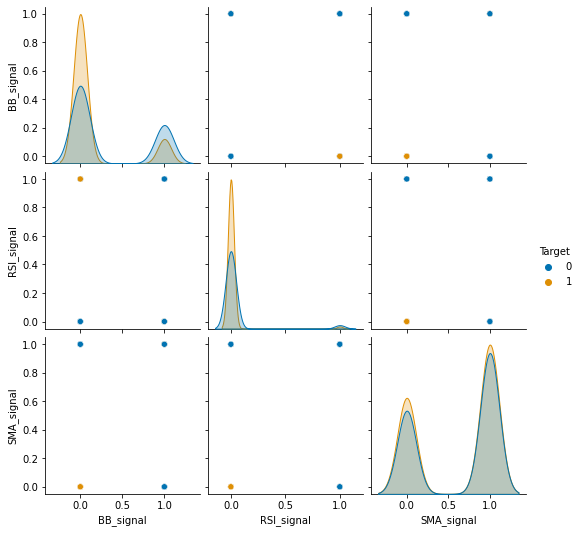

In [151]:
# use pairplots to visualize strength of signals 
sns.pairplot(signals_df[signals+['Target']],hue='Target',palette='colorblind')

## Prepare the Machine Learning Models
---

### Split the data into training and testing datasets

In [152]:
# Assign Target column to a features DataFrame called X
X = signals_df[signals].iloc[:-1]

# Review the DataFrame
X.tail()     

BB_signal  RSI_signal  SMA_signal
Date                                         
2020-12-23        0.0         0.0         1.0
2020-12-24        1.0         0.0         1.0
2020-12-28        1.0         0.0         1.0
2020-12-29        1.0         0.0         1.0
2020-12-30        1.0         0.0         1.0

In [153]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df.iloc[:-1]['Target']

# Review the value counts
y.value_counts()

1    1438
0    1321
Name: Target, dtype: int64

In [154]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2010-01-15 00:00:00


In [155]:
# Select the ending period for the training data with an offset of 14 years (70%)
training_end = training_begin + DateOffset(years=7)

# Display the training end date
print(training_end)

2017-01-15 00:00:00


In [156]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

BB_signal  RSI_signal  SMA_signal
Date                                         
2017-01-09        0.0         0.0         1.0
2017-01-10        0.0         0.0         1.0
2017-01-11        0.0         0.0         1.0
2017-01-12        0.0         0.0         1.0
2017-01-13        1.0         0.0         1.0

In [157]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
X_test.head()

BB_signal  RSI_signal  SMA_signal
Date                                         
2017-01-17        1.0         0.0         1.0
2017-01-18        1.0         0.0         1.0
2017-01-19        1.0         0.0         1.0
2017-01-20        1.0         0.0         1.0
2017-01-23        0.0         0.0         1.0

In [158]:
#scale the data w/ minmax scaler as all obeservations are in range [-1:1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [159]:
X_train_scaled_df.describe().T.round(2)

count  mean   std  min  25%  50%  75%  max
BB_signal   1762.0  0.23  0.42  0.0  0.0  0.0  0.0  1.0
RSI_signal  1762.0  0.03  0.18  0.0  0.0  0.0  0.0  1.0
SMA_signal  1762.0  0.60  0.49  0.0  0.0  1.0  1.0  1.0

# Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression

# Create model
model = LogisticRegression(multi_class='multinomial')

# Train model
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [161]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

## Model Evaluation

In [162]:
from sklearn.metrics import accuracy_score

#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.6095346197502838
Model accuracy on testing data: 0.600802407221665
              precision    recall  f1-score   support

           0       0.68      0.33      0.44       483
           1       0.58      0.86      0.69       514

    accuracy                           0.60       997
   macro avg       0.63      0.59      0.57       997
weighted avg       0.63      0.60      0.57       997



## Backtesting

In [163]:
# Create a new empty predictions DataFrame.
predictions_df_LR = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_LR

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [164]:
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [165]:
predictions_df_LR['Target'] = y_test
# predictions_df_LR.drop(['Date'], axis=1)

# Add the model predictions to the DataFrame
predictions_df_LR['Predicted'] = y_pred

# Add the actual returns to the DataFrame
predictions_df_LR['Actual Returns'] = signals_df['Actual Returns']
predictions_df_LR

# Add the strategy returns to the DataFrame
predictions_df_LR['Strategy Returns'] = predictions_df_LR['Actual Returns'] * predictions_df_LR['Predicted'].shift()
predictions_df_LR

# add column for cumulative returns
predictions_df_LR['cumulative_rtns'] = (1 + (predictions_df_LR['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_LR['long_only_rtns'] = (1 + (predictions_df_LR['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_LR['Close'] = signals_df['Close']
predictions_df_LR

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_LR['Entry/Exit'] = predictions_df_LR['Predicted'].diff()


predictions_df_LR

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                   
2017-01-17  NaN          0       1       -0.013331               NaN   
2017-01-18  NaN          0       0        0.007102          0.000000   
2017-01-19  NaN          0       1       -0.002752         -0.000000   
2017-01-20  NaN          0       0        0.000862          0.000000   
2017-01-23  NaN          1       1       -0.001206         -0.000000   
...         ...        ...     ...             ...               ...   
2020-12-23  NaN          1       0       -0.015053         -0.015053   
2020-12-24  NaN          0       0        0.000000          0.000000   
2020-12-28  NaN          0       0       -0.003310         -0.000000   
2020-12-29  NaN          0       1       -0.011447         -0.000000   
2020-12-30  NaN          0       0        0.015726          0.000000   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-17              NaN        0.986669   57.730000         NaN  
2017-01-18         1.000000        0.993676   58.139999         0.0  
2017-01-19         1.000000        0.990942   57.980000         0.0  
2017-01-20         1.000000        0.991796   58.029999         0.0  
2017-01-23         1.000000        0.990600   57.959999         1.0  
...                     ...             ...         ...         ...  
2020-12-23        30.941571        2.426765  141.990005         0.0  
2020-12-24        30.941571        2.426765  141.990005        -1.0  
2020-12-28        30.941571        2.418732  141.520004         0.0  
2020-12-29        30.941571        2.391044  139.899994         0.0  
2020-12-30        30.941571        2.428645  142.100006         0.0  

[997 rows x 9 columns]

In [166]:
predictions_df_LR['Predicted'].value_counts()

1    766
0    231
Name: Predicted, dtype: int64

In [167]:
# Visualize exit position relative to close price
exit = predictions_df_LR[predictions_df_LR['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_LR[predictions_df_LR['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_LR[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

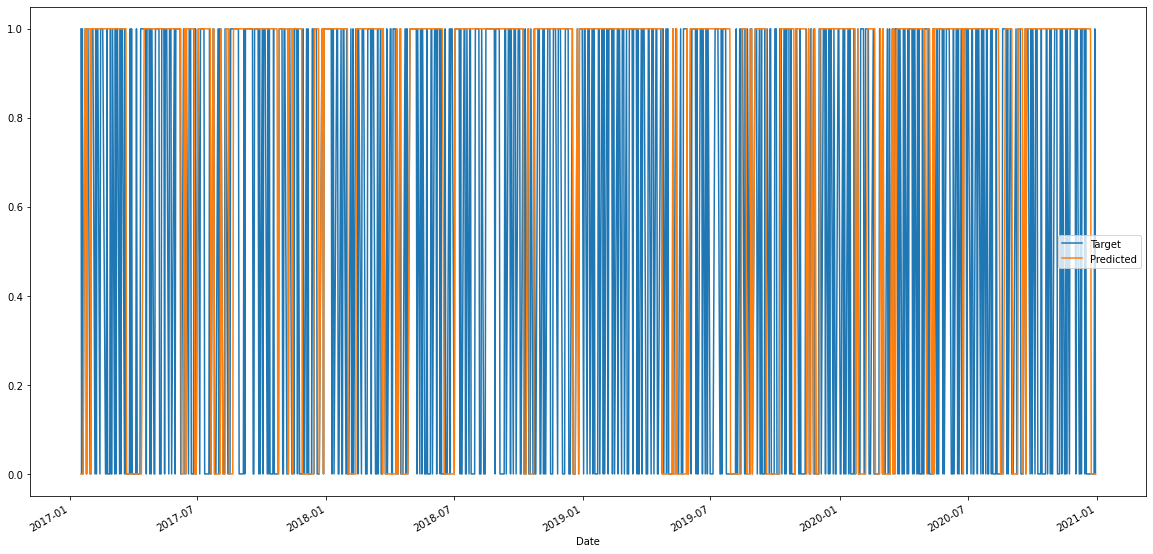

In [168]:
# Plot predicted results vs. actual results
predictions_df_LR[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

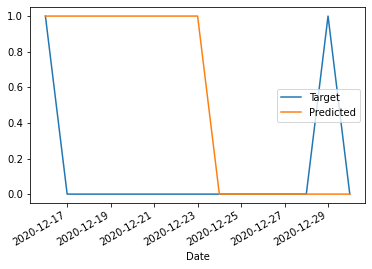

In [169]:
# Plot last 10 records of predicted vs. actual results
predictions_df_LR[['Target', 'Predicted']].tail(10).plot()

From 2017-01-17 to 2020-12-30, this trading algorithm has returned 2994.16% vs a long-only return of 142.86%


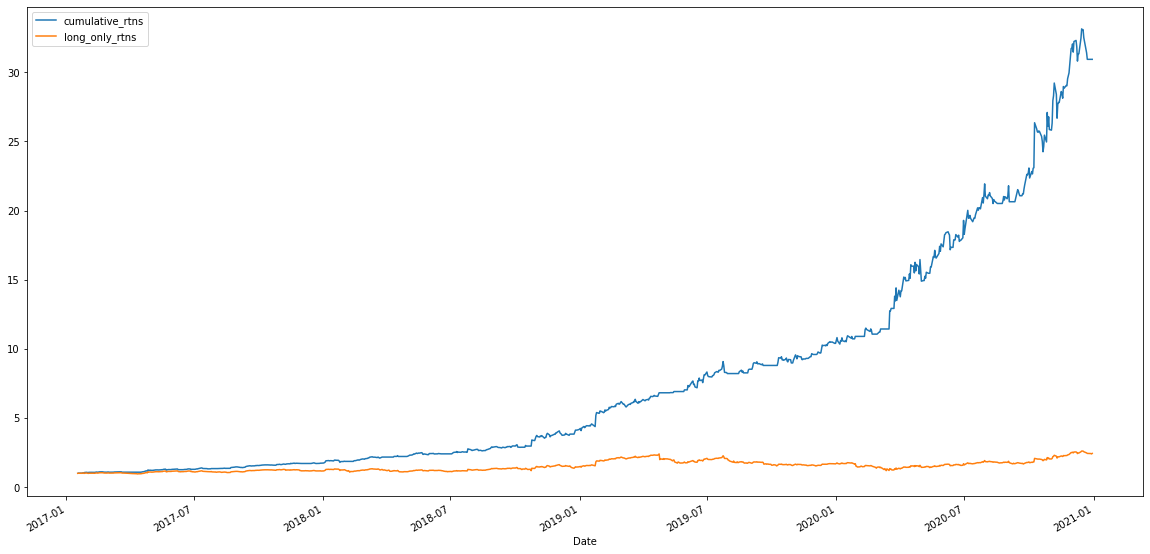

In [170]:
# Plot Cum Returns of Strategy
predictions_df_LR[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_LR['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_LR['long_only_rtns'].iloc[-1] - 1)*100


series_begin = predictions_df_LR.index.min().date()
series_end = predictions_df_LR.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

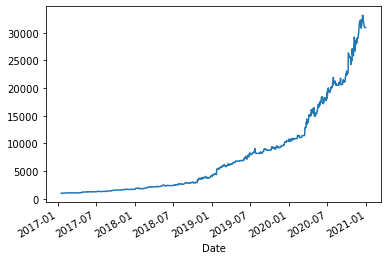

In [171]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_LR['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

## ADABoostClassifier

In [172]:
from sklearn.ensemble import AdaBoostClassifier

# Create model
model = AdaBoostClassifier()

# Train model
model.fit(X_train_scaled, y_train)

AdaBoostClassifier()

In [173]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [174]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.6095346197502838
Model accuracy on testing data: 0.600802407221665
              precision    recall  f1-score   support

           0       0.68      0.33      0.44       483
           1       0.58      0.86      0.69       514

    accuracy                           0.60       997
   macro avg       0.63      0.59      0.57       997
weighted avg       0.63      0.60      0.57       997



## Backtesting

In [175]:
# Create a new empty predictions DataFrame.
predictions_df_ADA = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_ADA

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [176]:
predictions_df_ADA['Date'] = y_test
predictions_df_ADA.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_ADA['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_ADA['Target']=signals_df['Target']
predictions_df_ADA

# Add the actual returns to the DataFrame
predictions_df_ADA['Actual Returns'] = signals_df['Actual Returns']
predictions_df_ADA

# Add the strategy returns to the DataFrame
predictions_df_ADA['Strategy Returns'] = predictions_df_ADA['Actual Returns'] * predictions_df_ADA['Predicted'].shift()
predictions_df_ADA

# add column for cumulative returns
predictions_df_ADA['cumulative_rtns'] = (1 + (predictions_df_ADA['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_ADA['long_only_rtns'] = (1 + (predictions_df_ADA['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_ADA['Close'] = signals_df['Close']
predictions_df_ADA

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_ADA['Entry/Exit'] = predictions_df_ADA['Predicted'].diff()


predictions_df_ADA

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-17     1          0       1       -0.013331               NaN   
2017-01-18     0          0       0        0.007102          0.000000   
2017-01-19     1          0       1       -0.002752         -0.000000   
2017-01-20     0          0       0        0.000862          0.000000   
2017-01-23     1          1       1       -0.001206         -0.000000   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.015053         -0.015053   
2020-12-24     0          0       0        0.000000          0.000000   
2020-12-28     0          0       0       -0.003310         -0.000000   
2020-12-29     1          0       1       -0.011447         -0.000000   
2020-12-30     0          0       0        0.015726          0.000000   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-17              NaN        0.986669   57.730000         NaN  
2017-01-18         1.000000        0.993676   58.139999         0.0  
2017-01-19         1.000000        0.990942   57.980000         0.0  
2017-01-20         1.000000        0.991796   58.029999         0.0  
2017-01-23         1.000000        0.990600   57.959999         1.0  
...                     ...             ...         ...         ...  
2020-12-23        30.941571        2.426765  141.990005         0.0  
2020-12-24        30.941571        2.426765  141.990005        -1.0  
2020-12-28        30.941571        2.418732  141.520004         0.0  
2020-12-29        30.941571        2.391044  139.899994         0.0  
2020-12-30        30.941571        2.428645  142.100006         0.0  

[997 rows x 9 columns]

In [177]:
# Visualize exit position relative to close price
exit = predictions_df_ADA[predictions_df_ADA['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_ADA[predictions_df_ADA['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_ADA[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

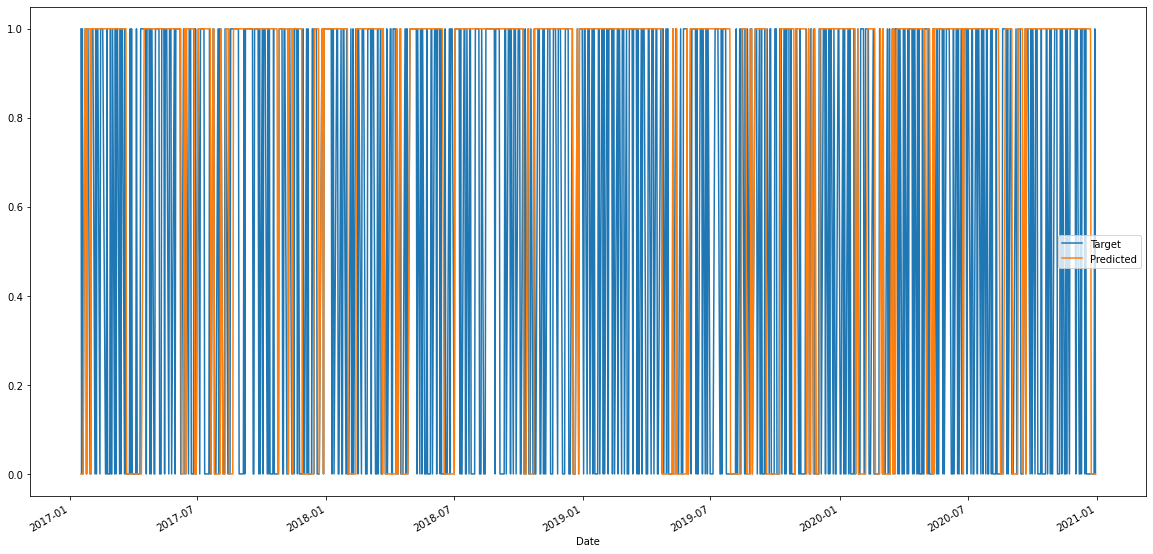

In [178]:
# Plot predicted results vs. actual results
predictions_df_ADA[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

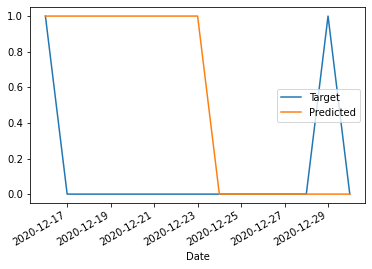

In [179]:
# Plot last 10 records of predicted vs. actual results
predictions_df_ADA[['Target', 'Predicted']].tail(10).plot()

From 2017-01-17 to 2020-12-30, this trading algorithm has returned 2994.16% vs a long-only return of 142.86%


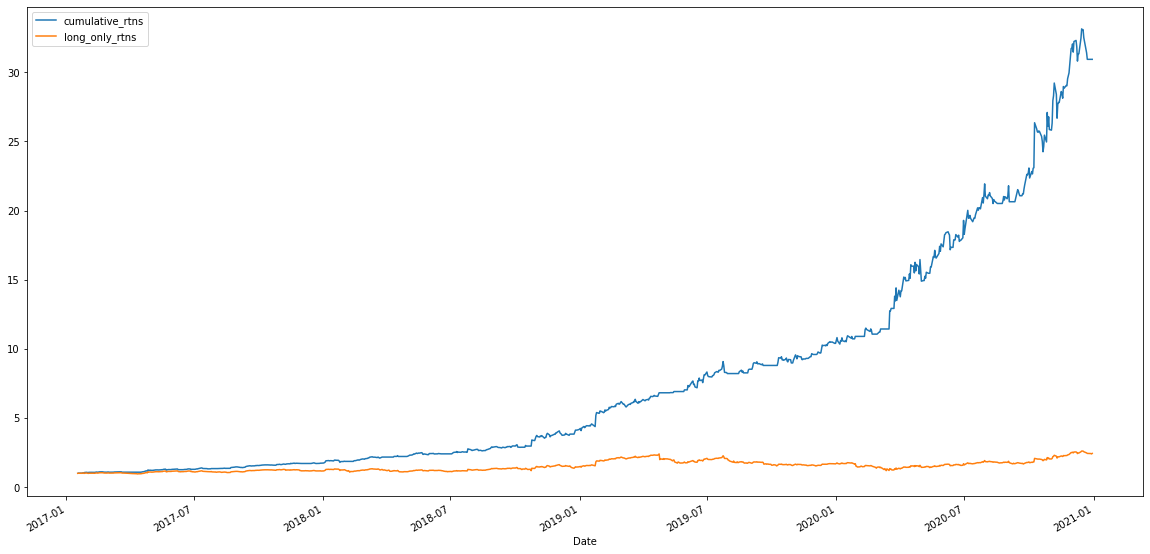

In [180]:
# Plot Cum Returns of Strategy
predictions_df_ADA[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_ADA['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_ADA['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_ADA.index.min().date()
series_end = predictions_df_ADA.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

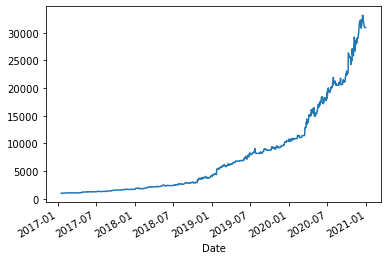

In [181]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_ADA['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# DecisionTree Classifier

In [182]:
from sklearn.tree import DecisionTreeClassifier

# Create model
model = DecisionTreeClassifier()

# Train model
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [183]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [184]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.6112372304199774
Model accuracy on testing data: 0.600802407221665
              precision    recall  f1-score   support

           0       0.68      0.33      0.44       483
           1       0.58      0.86      0.69       514

    accuracy                           0.60       997
   macro avg       0.63      0.59      0.57       997
weighted avg       0.63      0.60      0.57       997



## Backtesting

In [185]:
# Create a new empty predictions DataFrame.
predictions_df_DT = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_DT

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [186]:
predictions_df_DT['Date'] = y_test
predictions_df_DT.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_DT['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_DT['Target']=signals_df['Target']
predictions_df_DT

# Add the actual returns to the DataFrame
predictions_df_DT['Actual Returns'] = signals_df['Actual Returns']
predictions_df_DT

# Add the strategy returns to the DataFrame
predictions_df_DT['Strategy Returns'] = predictions_df_DT['Actual Returns'] * predictions_df_DT['Predicted'].shift()
predictions_df_DT

# add column for cumulative returns
predictions_df_DT['cumulative_rtns'] = (1 + (predictions_df_DT['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_DT['long_only_rtns'] = (1 + (predictions_df_DT['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_DT['Close'] = signals_df['Close']
predictions_df_DT

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_DT['Entry/Exit'] = predictions_df_DT['Predicted'].diff()


predictions_df_DT

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-17     1          0       1       -0.013331               NaN   
2017-01-18     0          0       0        0.007102          0.000000   
2017-01-19     1          0       1       -0.002752         -0.000000   
2017-01-20     0          0       0        0.000862          0.000000   
2017-01-23     1          1       1       -0.001206         -0.000000   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.015053         -0.015053   
2020-12-24     0          0       0        0.000000          0.000000   
2020-12-28     0          0       0       -0.003310         -0.000000   
2020-12-29     1          0       1       -0.011447         -0.000000   
2020-12-30     0          0       0        0.015726          0.000000   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-17              NaN        0.986669   57.730000         NaN  
2017-01-18         1.000000        0.993676   58.139999         0.0  
2017-01-19         1.000000        0.990942   57.980000         0.0  
2017-01-20         1.000000        0.991796   58.029999         0.0  
2017-01-23         1.000000        0.990600   57.959999         1.0  
...                     ...             ...         ...         ...  
2020-12-23        30.941571        2.426765  141.990005         0.0  
2020-12-24        30.941571        2.426765  141.990005        -1.0  
2020-12-28        30.941571        2.418732  141.520004         0.0  
2020-12-29        30.941571        2.391044  139.899994         0.0  
2020-12-30        30.941571        2.428645  142.100006         0.0  

[997 rows x 9 columns]

In [187]:
# Visualize exit position relative to close price
exit = predictions_df_DT[predictions_df_DT['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_DT[predictions_df_DT['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_DT[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

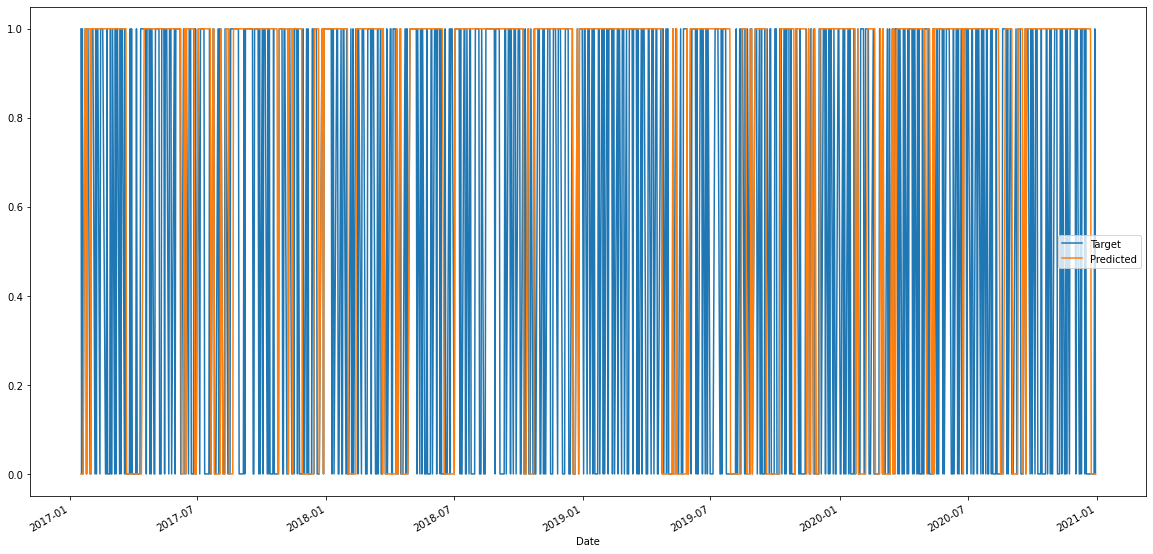

In [188]:
# Plot predicted results vs. actual results
predictions_df_DT[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

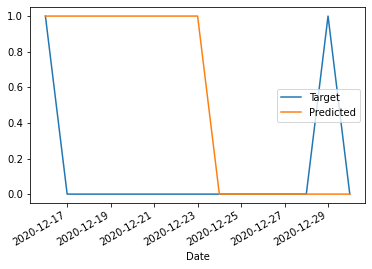

In [189]:
# Plot last 10 records of predicted vs. actual results
predictions_df_DT[['Target', 'Predicted']].tail(10).plot()

From 2017-01-17 to 2020-12-30, this trading algorithm has returned 2994.16% vs a long-only return of 142.86%


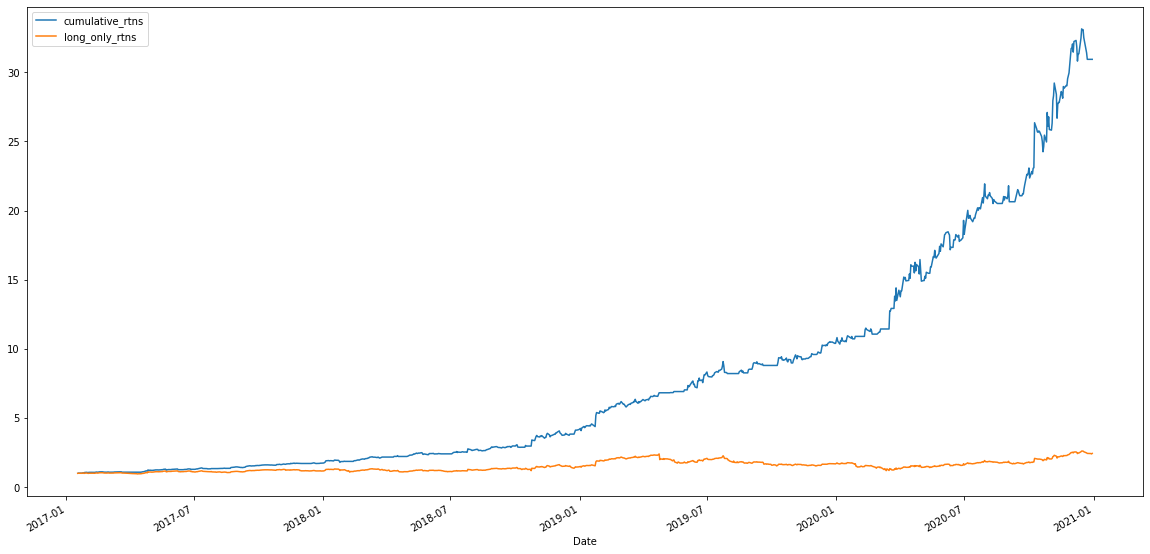

In [190]:
# Plot Cum Returns of Strategy
predictions_df_DT[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_DT['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_DT['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_DT.index.min().date()
series_end = predictions_df_DT.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

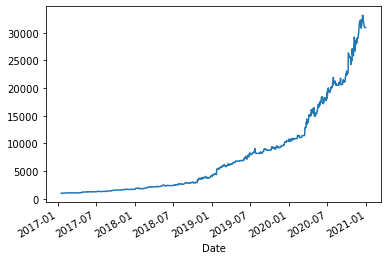

In [191]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_DT['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Gradient Boosting Classifier

In [192]:
from sklearn.ensemble import GradientBoostingClassifier

# Create model
model = GradientBoostingClassifier()

# Train model
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [193]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [194]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.6112372304199774
Model accuracy on testing data: 0.600802407221665
              precision    recall  f1-score   support

           0       0.68      0.33      0.44       483
           1       0.58      0.86      0.69       514

    accuracy                           0.60       997
   macro avg       0.63      0.59      0.57       997
weighted avg       0.63      0.60      0.57       997



## Backtesting

In [195]:
# Create a new empty predictions DataFrame.
predictions_df_GBC = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_GBC

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [196]:
predictions_df_GBC['Date'] = y_test
predictions_df_GBC.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_GBC['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_GBC['Target']=signals_df['Target']
predictions_df_GBC

# Add the actual returns to the DataFrame
predictions_df_GBC['Actual Returns'] = signals_df['Actual Returns']
predictions_df_GBC

# Add the strategy returns to the DataFrame
predictions_df_GBC['Strategy Returns'] = predictions_df_GBC['Actual Returns'] * predictions_df_GBC['Predicted'].shift()
predictions_df_GBC

# add column for cumulative returns
predictions_df_GBC['cumulative_rtns'] = (1 + (predictions_df_GBC['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_GBC['long_only_rtns'] = (1 + (predictions_df_GBC['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_GBC['Close'] = signals_df['Close']
predictions_df_GBC

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_GBC['Entry/Exit'] = predictions_df_GBC['Predicted'].diff()


predictions_df_GBC

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-17     1          0       1       -0.013331               NaN   
2017-01-18     0          0       0        0.007102          0.000000   
2017-01-19     1          0       1       -0.002752         -0.000000   
2017-01-20     0          0       0        0.000862          0.000000   
2017-01-23     1          1       1       -0.001206         -0.000000   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.015053         -0.015053   
2020-12-24     0          0       0        0.000000          0.000000   
2020-12-28     0          0       0       -0.003310         -0.000000   
2020-12-29     1          0       1       -0.011447         -0.000000   
2020-12-30     0          0       0        0.015726          0.000000   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-17              NaN        0.986669   57.730000         NaN  
2017-01-18         1.000000        0.993676   58.139999         0.0  
2017-01-19         1.000000        0.990942   57.980000         0.0  
2017-01-20         1.000000        0.991796   58.029999         0.0  
2017-01-23         1.000000        0.990600   57.959999         1.0  
...                     ...             ...         ...         ...  
2020-12-23        30.941571        2.426765  141.990005         0.0  
2020-12-24        30.941571        2.426765  141.990005        -1.0  
2020-12-28        30.941571        2.418732  141.520004         0.0  
2020-12-29        30.941571        2.391044  139.899994         0.0  
2020-12-30        30.941571        2.428645  142.100006         0.0  

[997 rows x 9 columns]

In [197]:
# Visualize exit position relative to close price
exit = predictions_df_GBC[predictions_df_GBC['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_GBC[predictions_df_GBC['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_GBC[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

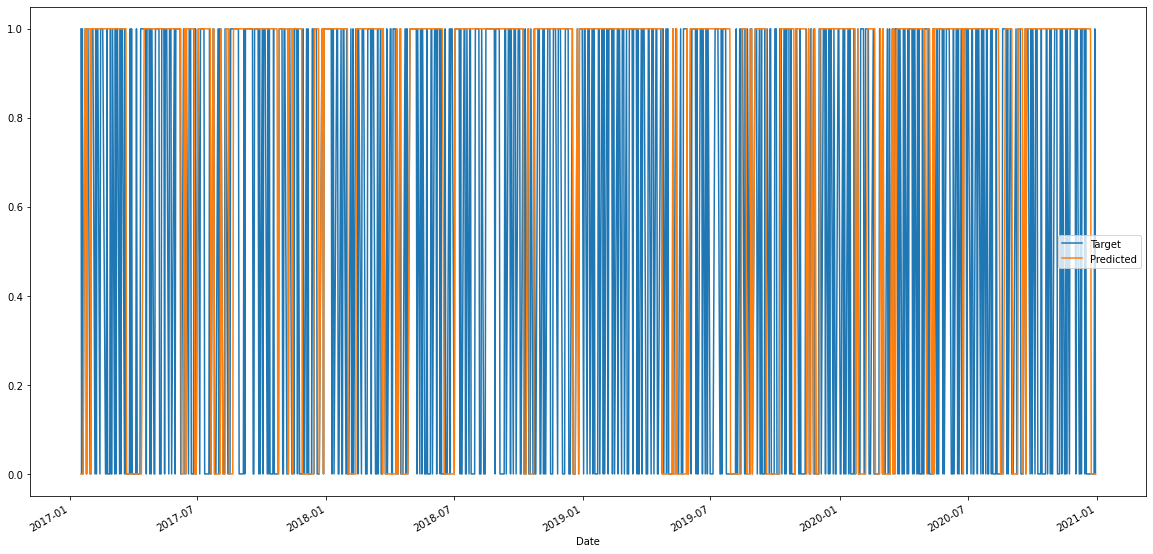

In [198]:
# Plot predicted results vs. actual results
predictions_df_GBC[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

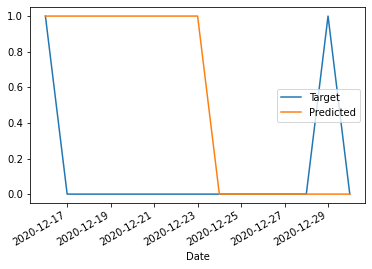

In [199]:
# Plot last 10 records of predicted vs. actual results
predictions_df_GBC[['Target', 'Predicted']].tail(10).plot()

From 2017-01-17 to 2020-12-30, this trading algorithm has returned 2994.16% vs a long-only return of 142.86%


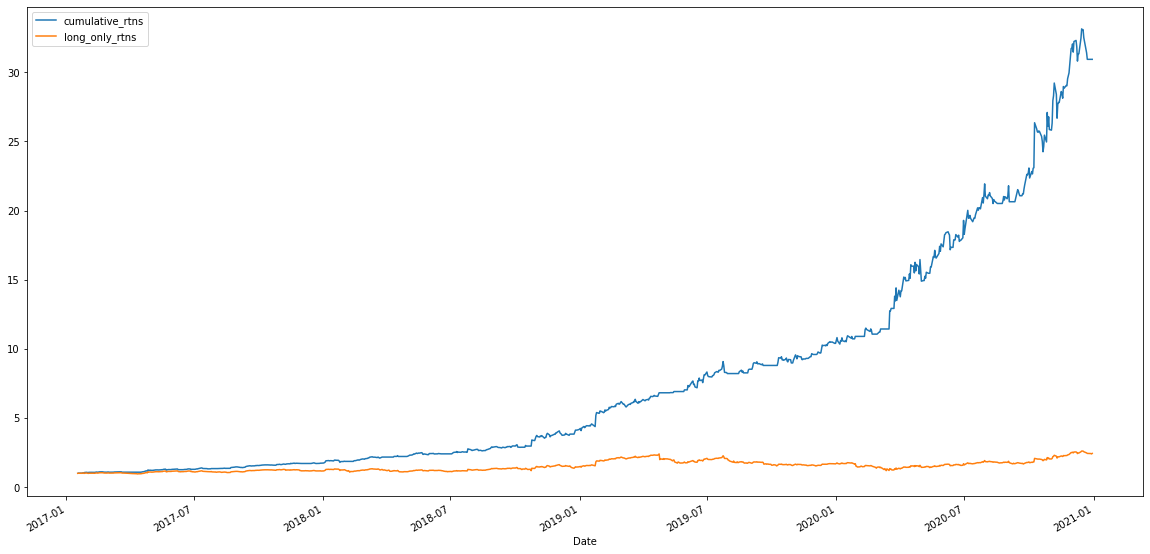

In [200]:
# Plot Cum Returns of Strategy
predictions_df_GBC[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_GBC['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_GBC['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_GBC.index.min().date()
series_end = predictions_df_GBC.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

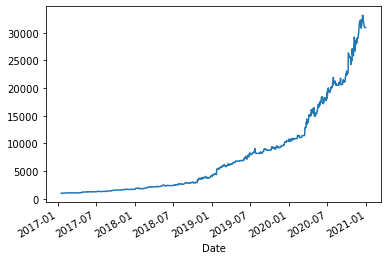

In [201]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_GBC['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Evaluation
___

## Prep Evaluation Metrics Dataframe

In [202]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',]

columns = ['Long Only', 'Logistic Regression', 'RandomForest', 'Gradient Boosting', 'Decision Tree', 'ADABoost']

# Initialize the DataFrame with index set to evaluation metrics and column = trading staregy
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

Long Only Logistic Regression RandomForest  \
Annual Return            NaN                 NaN          NaN   
Cumulative Returns       NaN                 NaN          NaN   
Annual Volatility        NaN                 NaN          NaN   
Sharpe Ratio             NaN                 NaN          NaN   

                   Gradient Boosting Decision Tree ADABoost  
Annual Return                    NaN           NaN      NaN  
Cumulative Returns               NaN           NaN      NaN  
Annual Volatility                NaN           NaN      NaN  
Sharpe Ratio                     NaN           NaN      NaN

## Calculate and Assign Portfolio Metrics

In [203]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns']['Long Only'] = (predictions_df_LR['long_only_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Logistic Regression'] = (predictions_df_LR['cumulative_rtns'].iloc[-1] - 1)*100
# portfolio_evaluation_df.loc['Cumulative Returns']['RandomForest'] = (predictions_df_RF['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Gradient Boosting'] = (predictions_df_GBC['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Decision Tree'] = (predictions_df_DT['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['ADABoost'] = (predictions_df_ADA['cumulative_rtns'].iloc[-1] - 1)*100


# # Calculate annualized return
portfolio_evaluation_df.loc['Annual Return']['Long Only'] = (predictions_df_LR['Actual Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].mean() * 252)*100
# portfolio_evaluation_df.loc['Annual Return']['RandomForest'] = (predictions_df_RF['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].mean() * 252)*100


# # Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility']['Long Only'] = (predictions_df_LR['Actual Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].std() * np.sqrt(252))*100
# portfolio_evaluation_df.loc['Annual Volatility']['RandomForest'] = (predictions_df_RF['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].std() * np.sqrt(252))*100


# # Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio']['Long Only'] = (predictions_df_LR['Actual Returns'].mean() * 252) / (predictions_df_LR['Actual Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].mean() * 252) / (predictions_df_LR['Strategy Returns'].std() * np.sqrt(252))
# portfolio_evaluation_df.loc['Sharpe Ratio']['RandomForest'] = (predictions_df_RF['Strategy Returns'].mean() * 252) / (predictions_df_RF['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].mean() * 252) / (predictions_df_GBC['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].mean() * 252) / (predictions_df_DT['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].mean() * 252) / (predictions_df_ADA['Strategy Returns'].std() * np.sqrt(252))


portfolio_evaluation_df.head()


Long Only Logistic Regression RandomForest  \
Annual Return        29.805275           91.739816          NaN   
Cumulative Returns  142.864485         2994.157143          NaN   
Annual Volatility     38.54628           31.288861          NaN   
Sharpe Ratio          0.773234            2.932028          NaN   

                   Gradient Boosting Decision Tree     ADABoost  
Annual Return              91.739816     91.739816    91.739816  
Cumulative Returns       2994.157143   2994.157143  2994.157143  
Annual Volatility          31.288861     31.288861    31.288861  
Sharpe Ratio                2.932028      2.932028     2.932028